# Impor pustaka yang diperlukan

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


Mengimpor pustaka yang akan digunakan: pandas dan numpy untuk manipulasi data, matplotlib dan seaborn untuk visualisasi, dan beberapa modul dari sklearn untuk pengembangan dan evaluasi model.

# Memuat Data

In [33]:
!pip install kaggle

from google.colab import files
files.upload()

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle datasets download -d rishidamarla/costs-for-cancer-treatment

!unzip costs-for-cancer-treatment.zip

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/rishidamarla/costs-for-cancer-treatment
License(s): CC0-1.0
costs-for-cancer-treatment.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  costs-for-cancer-treatment.zip
replace DowloadableDataFull_2011.01.12.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: DowloadableDataFull_2011.01.12.csv  


Mengunduh dataset dari Kaggle dan mengekstrak data.

# Memuat dataset dan eksplorasi awal

### Muat dataset

In [34]:
url = 'DowloadableDataFull_2011.01.12.csv'
data = pd.read_csv(url, skiprows=2)
data.columns = data.iloc[0]
data = data[1:]

Memuat dataset, menghapus baris pertama yang mengandung header, dan menyesuaikan nama kolom.

### Ubah kolom menjadi numerik

In [35]:
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data['Total Costs'] = pd.to_numeric(data['Total Costs'], errors='coerce')


Mengonversi kolom Year dan Total Costs menjadi tipe numerik untuk perhitungan.

In [36]:
print(data.head())

0 Cancer Site  Year         Sex       Age  \
1    AllSites  2010  Both sexes  All ages   
2    AllSites  2010  Both sexes  All ages   
3    AllSites  2010  Both sexes  All ages   
4    AllSites  2010  Both sexes  All ages   
5    AllSites  2010  Both sexes  All ages   

0                 Incidence and Survival Assumptions  \
1               Incidence, Survival at constant rate   
2  Incidence follows recent trend, Survival constant   
3  Survival follows recent trend, Incidence constant   
4           Incidence, Survival follow recent trends   
5           Incidence, Survival follow recent trends   

0 Annual Cost Increase (applied to initial and last phases)  Total Costs  \
1                                                 0%            124565.6   
2                                                 0%            122420.8   
3                                                 0%            125397.7   
4                                                 0%            123236.3   
5           

## Deskripsi Variabel

### Tampilkan nama kolom dan tipe data

In [37]:
print("Tipe Data dan Nilai Null:\n", data.info())
print("Statistik Ringkas:\n", data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 1 to 1254
Data columns (total 10 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Cancer Site                                                1254 non-null   object 
 1   Year                                                       1254 non-null   int64  
 2   Sex                                                        1254 non-null   object 
 3   Age                                                        1254 non-null   object 
 4   Incidence and Survival Assumptions                         1254 non-null   object 
 5   Annual Cost Increase (applied to initial and last phases)  1254 non-null   object 
 6   Total Costs                                                1254 non-null   float64
 7   Initial Year After Diagnosis Cost                          1254 non-null   object 
 8   Continui

### Memeriksa apakah ada nilai yang hilang pada kolom-kolom dalam dataset.

In [38]:
print("Pemeriksaan Missing Values:")
print(data.isnull().sum())

Pemeriksaan Missing Values:
0
Cancer Site                                                  0
Year                                                         0
Sex                                                          0
Age                                                          0
Incidence and Survival Assumptions                           0
Annual Cost Increase (applied to initial and last phases)    0
Total Costs                                                  0
Initial Year After Diagnosis Cost                            0
Continuing Phase Cost                                        0
Last Year of Life Cost                                       0
dtype: int64


### Memeriksa apakah ada duplikasi data.

In [39]:
print("\nPemeriksaan Duplikat:")
print(f"Jumlah baris duplikat: {data.duplicated().sum()}")


Pemeriksaan Duplikat:
Jumlah baris duplikat: 0


### Plot diagram batang untuk 'Cancer Site'

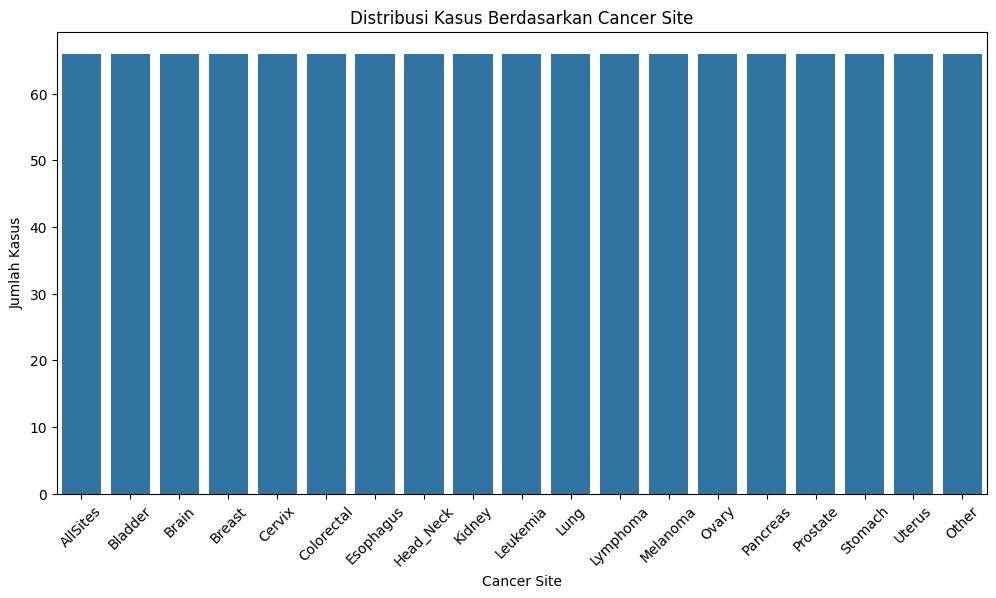

In [40]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Cancer Site', data=data)

plt.title('Distribusi Kasus Berdasarkan Cancer Site')
plt.xlabel('Cancer Site')
plt.ylabel('Jumlah Kasus')

plt.xticks(rotation=45)

plt.show()

Diagram menunjukan jumlah kasus sama masning 66 kasus.

### Diagram Batang untuk Total Costs berdasarkan Cancer Site

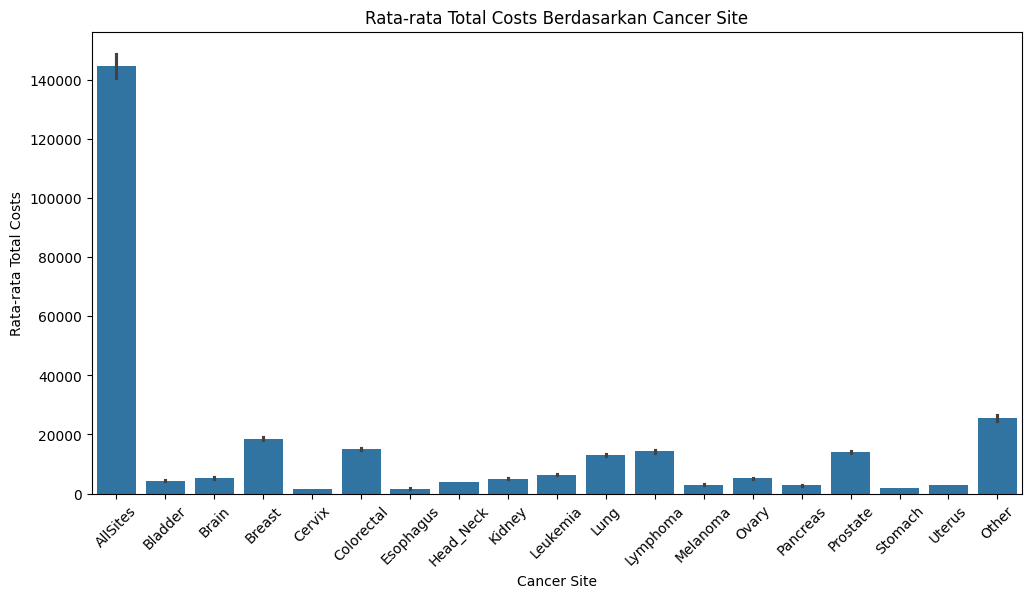

In [41]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Cancer Site', y='Total Costs', data=data, estimator='mean')

plt.title('Rata-rata Total Costs Berdasarkan Cancer Site')
plt.xlabel('Cancer Site')
plt.ylabel('Rata-rata Total Costs')

plt.xticks(rotation=45)

plt.show()

diagram menunjukan biaya terbesar secara berurut yaitu all sites, other , breast, colorectal, lymphoma

### diagram batang untuk Total Costs berdasarkan Cancer Site dan Sex

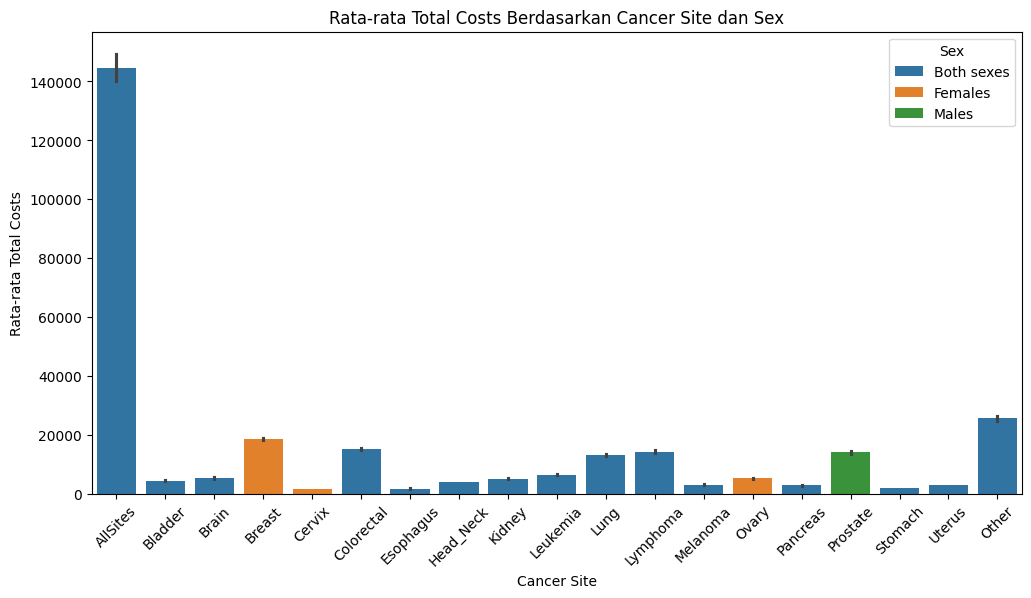

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Cancer Site', y='Total Costs', hue='Sex', data=data)

plt.title('Rata-rata Total Costs Berdasarkan Cancer Site dan Sex')
plt.xlabel('Cancer Site')
plt.ylabel('Rata-rata Total Costs')

plt.xticks(rotation=45)

plt.show()

diagram menunjukan yang paling banyak untuk wanita yaitu breast dan yang paling banyak untuk pria yaitu prostat.

# Persiapan Data

### Menghapus simbol '%' pada kolom 'Annual Cost Increase' dan mengonversinya menjadi float

In [43]:
data['Annual Cost Increase (applied to initial and last phases)'] = (
    data['Annual Cost Increase (applied to initial and last phases)']
    .replace('%', '', regex=True)
    .astype(float) / 100
)

Proses ini dilakukan untuk membersihkan dan mengonversi data dari format string ke format numerik (float). Simbol '%' dihapus agar kolom tersebut dapat dikonversi menjadi nilai float dan diubah menjadi bentuk desimal dengan membagi 10

### One-Hot Encoding untuk kolom kategorikal

In [44]:
data_encoded = pd.get_dummies(data, columns=['Cancer Site', 'Sex', 'Age', 'Incidence and Survival Assumptions'], drop_first=True)


One-Hot Encoding digunakan untuk mengubah data kategorikal menjadi format numerik dengan cara membuat kolom biner (0 dan 1) untuk setiap kategori yang ada.

### Tampilkan 5 baris pertama untuk inspeksi awal

In [45]:
print(data.head())

0 Cancer Site  Year         Sex       Age  \
1    AllSites  2010  Both sexes  All ages   
2    AllSites  2010  Both sexes  All ages   
3    AllSites  2010  Both sexes  All ages   
4    AllSites  2010  Both sexes  All ages   
5    AllSites  2010  Both sexes  All ages   

0                 Incidence and Survival Assumptions  \
1               Incidence, Survival at constant rate   
2  Incidence follows recent trend, Survival constant   
3  Survival follows recent trend, Incidence constant   
4           Incidence, Survival follow recent trends   
5           Incidence, Survival follow recent trends   

0  Annual Cost Increase (applied to initial and last phases)  Total Costs  \
1                                               0.00             124565.6   
2                                               0.00             122420.8   
3                                               0.00             125397.7   
4                                               0.00             123236.3   
5      

### Tentukan fitur dan target

In [46]:
fitur = data_encoded.drop(columns=['Total Costs'])  # Gantilah dengan nama kolom target jika berbeda
target = data_encoded['Total Costs']

Proses ini memisahkan variabel independen (fitur) dari variabel dependen (target) yang akan diprediksi.

### Pisahkan data menjadi set pelatihan dan pengujian

In [47]:
X_train, X_test, y_train, y_test = train_test_split(fitur, target, test_size=0.2, random_state=42)

Data dibagi menjadi set pelatihan (80%) dan set pengujian (20%). random_state=42 digunakan untuk memastikan hasil pembagian yang konsisten di setiap eksekusi.

### Cek ukuran sampel

In [48]:
print("Jumlah sampel pelatihan:", len(X_train))
print("Jumlah sampel pengujian:", len(X_test))

Jumlah sampel pelatihan: 1003
Jumlah sampel pengujian: 251


### Standarisasi fitur

In [49]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Rata-rata X_train:", X_train.mean(axis=0))
print("Deviasi standar X_train:", X_train.std(axis=0))

Rata-rata X_train: [-1.30472790e-14  1.23973060e-17  0.00000000e+00 -6.46430954e-17
  4.11767662e-17 -3.36498305e-17 -7.43838357e-17  5.75589205e-17
  7.08417483e-18 -2.47946119e-17 -7.08417483e-18 -6.02154861e-17
  6.02154861e-17 -1.77104371e-17  2.83366993e-17  1.06262622e-17
  3.09932649e-17 -8.50100980e-17  2.47946119e-17 -5.49023550e-17
 -2.74511775e-17 -8.14680106e-17  6.72996609e-17 -6.37575735e-17
 -2.74511775e-17  1.45225584e-16 -5.66733987e-17 -2.65656556e-17]
Deviasi standar X_train: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


Standarisasi dilakukan untuk menyelaraskan skala fitur-fitur dalam dataset agar memiliki distribusi yang sama (mean 0 dan standar deviasi 1).

# Pengembangan Model

### DataFrame untuk perbandingan model

In [50]:
hasil_model = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2'])

Membuat DataFrame kosong untuk menyimpan hasil evaluasi model.

## Random Forest Regressor

### Tahap pertama dengan parameter default

In [51]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

Kode ini melatih model Random Forest Regressor dengan data pelatihan, kemudian menggunakan model tersebut untuk memprediksi target pada data uji. Model ini diinisialisasi dengan parameter default, kecuali random_state=42 untuk hasil yang konsisten. Setelah memprediksi, kinerja model dievaluasi menggunakan tiga metrik utama: Mean Squared Error (MSE) untuk mengukur rata-rata kesalahan kuadrat antara prediksi dan nilai sebenarnya, Root Mean Squared Error (RMSE) untuk interpretasi kesalahan dalam skala yang sama dengan target, dan R² untuk menilai seberapa baik model menjelaskan variasi dalam data.

### Tambahkan hasil Random Forest dengan parameter default ke dalam hasil_model

In [52]:
hasil_model = pd.concat([hasil_model, pd.DataFrame({'Model': ['Random Forest (default)'], 'MSE': [mse_rf], 'RMSE': [rmse_rf], 'R2': [r2_rf]})], ignore_index=True)


<ipython-input-52-c34ba99a4ef1>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hasil_model = pd.concat([hasil_model, pd.DataFrame({'Model': ['Random Forest (default)'], 'MSE': [mse_rf], 'RMSE': [rmse_rf], 'R2': [r2_rf]})], ignore_index=True)


Kode ini menambahkan hasil evaluasi model Random Forest ke dalam DataFrame hasil_model untuk membandingkan kinerja berbagai model. DataFrame baru dibuat dengan memasukkan nama model ("Random Forest (default)") beserta nilai evaluasi MSE, RMSE, dan R² yang telah dihitung sebelumnya. Kode pd.concat() digunakan untuk menggabungkan DataFrame ini dengan hasil_model, sehingga setiap model yang dievaluasi dapat dibandingkan dalam satu tabel. Parameter ignore_index=True memastikan bahwa indeks pada DataFrame hasil gabungan akan diurutkan ulang.

## Linear Regression

In [53]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

Kode ini melatih model Linear Regression pada data pelatihan untuk memprediksi biaya pengobatan pada data pengujian, kemudian menghitung metrik evaluasi: MSE, RMSE, dan R². Mean Squared Error (MSE) dan Root Mean Squared Error (RMSE) mengukur rata-rata kesalahan prediksi dalam satuan kuadrat dan aslinya, sedangkan R² menunjukkan seberapa baik model menjelaskan variasi data. Hasilnya memberikan gambaran tentang keakuratan model Linear Regression dalam memprediksi biaya pengobatan.

### Tambahkan hasil Linear Regression ke dalam hasil_model

In [54]:
hasil_model = pd.concat([hasil_model, pd.DataFrame({'Model': ['Linear Regression'], 'MSE': [mse_lr], 'RMSE': [rmse_lr], 'R2': [r2_lr]})], ignore_index=True)


Kode ini menambahkan hasil evaluasi model Linear Regression ke dalam DataFrame hasil_model untuk membandingkan kinerja model yang berbeda. Hasil evaluasi, yaitu Mean Squared Error (MSE), Root Mean Squared Error (RMSE), dan koefisien determinasi R², disimpan dalam DataFrame baru dan kemudian dikombinasikan (pd.concat) dengan hasil_model yang sudah ada. Dengan ignore_index=True, indeksnya diatur ulang sehingga setiap hasil ditampilkan dalam urutan yang bersih di hasil_model, yang mempermudah analisis komparatif antara model yang diuji.

# Evaluasi Model

### Tampilkan hasil evaluasi model


Hasil Evaluasi Model:
                      Model            MSE        RMSE        R2
0  Random Forest (default)  469475.096036  685.182528  0.999227
1        Linear Regression       0.003453    0.058760  1.000000


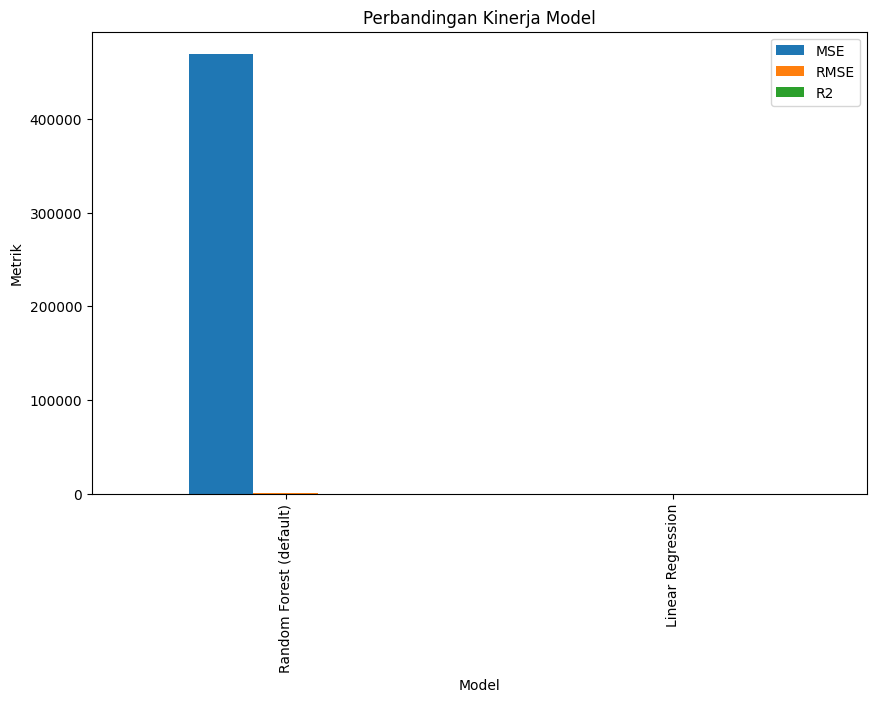

In [55]:
print("\nHasil Evaluasi Model:\n", hasil_model)

fig, ax = plt.subplots(figsize=(10, 6))
hasil_model.set_index('Model')[['MSE', 'RMSE', 'R2']].plot(kind='bar', ax=ax)
plt.title("Perbandingan Kinerja Model")
plt.ylabel("Metrik")
plt.show()

Membuat visualisasi perbandingan kinerja model berdasarkan MSE, RMSE, dan R².

### Prediksi dan pengujian dengan model Linear Regression

In [26]:
y_pred_lr_test = lr_model.predict(X_test)


Model Linear Regression digunakan untuk membuat prediksi berdasarkan data uji (X_test). Hasil prediksi disimpan dalam y_pred_lr_test.

### Menghitung metrik evaluasi untuk Linear Regression pada data uji

In [27]:
mse_lr_test = mean_squared_error(y_test, y_pred_lr_test)
rmse_lr_test = np.sqrt(mse_lr_test)
r2_lr_test = r2_score(y_test, y_pred_lr_test)

Metrik evaluasi yang sama seperti di atas (MSE, RMSE, dan R²) dihitung untuk model Linear Regression.

In [28]:
print("Model Linear Regression - Evaluasi Set Pengujian")
print(f"MSE: {mse_lr_test:.2f}")
print(f"RMSE: {rmse_lr_test:.2f}")
print(f"R²: {r2_lr_test:.2f}")
print("\n")

Model Linear Regression - Evaluasi Set Pengujian
MSE: 0.00
RMSE: 0.06
R²: 1.00




### Prediksi dan pengujian dengan model Random Forest Regressor

In [29]:
y_pred_rf_test = rf_model.predict(X_test)

Model Random Forest Regressor digunakan untuk membuat prediksi berdasarkan data uji (X_test). Hasil prediksi disimpan dalam y_pred_rf_test.

### Menghitung metrik evaluasi untuk Random Forest pada data uji

In [30]:
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
rmse_rf_test = np.sqrt(mse_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

Metrik evaluasi yang sama seperti di atas (MSE, RMSE, dan R²) dihitung untuk model Random Forest Regressor.

In [31]:
print("Model Random Forest - Evaluasi Set Pengujian")
print(f"MSE: {mse_rf_test:.2f}")
print(f"RMSE: {rmse_rf_test:.2f}")
print(f"R²: {r2_rf_test:.2f}")

Model Random Forest - Evaluasi Set Pengujian
MSE: 469475.10
RMSE: 685.18
R²: 1.00
